# Chaos: An Extremely Brief Primer

## Is the weather random?
From time-to-time you might hear that the atmosphere (or even the Earth System, more generally) is "chaotic." What does that mean? Does it mean that things like hurricanes, and weather systems behave in a truly random way and can never be predicted, as the term "chaos" seems to imply? 

In short, no. The Earth System and atmosphere do not, as far as we know, demonstrate truly random behavior in same way that happens when you roll a pair of dice or draw randomly from a deck of well-shuffled cards. The atmosphere is, in fact, a deterministic system that conforms to fundamental laws that conserve mass, energy, and momentum. We can, and have, written down the equations that describe the motion of air within the Earth's atmosphere by applying these fundamental principles of conservation, and by using some important mathematical principles that allow us to account for the fact that we're on a rotating, approximately sphere planet.  

## Then what is chaos?
If we, in fact, know the equations describing the movement of air in Earth's atmosphere, then why is it said that it is chaotic? There are, unfortunately a few major problems with the equations of motion as they are known:

1. As far as we know, there is no analytical and closed-form solution to those equations. That is, we cannot rearrange the terms of the equation such that we get expressions for the velocity, pressure, temperature, and humidity everywhere in the atmosphere as a function of things that are known. The equations must be solved numerically on high performance computing clusters, which requires that we turn these continuous equations into a numerical model based on discrete equations - something that requires that we assume the those state variables are approximately linear if we take small steps in space and time.
2. The form of the equations are strongly nonlinear. What this means is that there are terms that appear in the governing equations that have state variables (velocity, in particular) that are multiplied by derivatives of themselves. As a result, the underlying variables of interest  change very rapidly with small changes in either distance, time, or both. And because we have to develop numerical approximations that assume locally linear behavior, our numerical approximations grow increasingly bad the further out into the future we run our model. Moreover, the bigger the spatial or temporal step we take when solving those equations, the more quickly our model begins to diverge from the true state.   
3. The same numerical approximations to the governing equations require that we start with an initial guess of "state" of the atmosphere: the spatial distribution of velocity, pressure, temperature, and humidity at the beginning of our model run. While satellite data and surface meteorological observations provide us a pretty good estimate of the state of the atmosphere, there are nevertheless uncertainties in that estimate (and likely always will be). 

Putting these factors together the upshot is that we don't perfectly know the initial condition we need to start our model and, because the atmosphere is so nonlinear, those errors in the initial condition can become very large very rapidly because of the numerically approximate nature of our model. This is more appropriately termed "sensitive dependence to the initial conditions." That is, small errors in our understanding of the initial condition grow ever larger the further out into the future we run the model. Importantly, this is not to say that the model produces physically unrealistic or impossible solutions in the future (i.e., that the model "diverges" from reality). The predictions the model generates will be consistent with the physics of the problem, just exceedingly unlikely to occur as predicted.   

## How was this sensitive dependence discovered?

In this Jupyter Notebook, we're going to approximate the experiment that the late Ed Lorenz, a professor of Atmospheric Science at MIT, performed in which he accidentally discovered what is now called chaos. 

![EdLorenz](img/Edward_lorenz.jpg)

In the 1960s (and even today), running models of the atmosphere required significant computational power. To explore some of the behavior of the predictability of the atmosphere, Ed Lorenz (along with other colleagues outside of MIT) developed relatively simple models that exhibited some of the mathematical behavior of the atmosphere, without being nearly as large or complex as full atmospheric models. In today's nomenclature, we might wall them "toy models." They are sufficiently simple that we can run them many thousands of times on a laptop (nowadays, at least). But they also mimic some of the key nonlinearities of the atmospheric system and, therefore, provide us with some important insights about how atmospheric models behave mathematically. There are many different kinds of these nonlinear "toy models," but here we will use the one that Ed Lorenz developed in 1963 on which he discovered sensitive dependence for the first time. 

## A toy model of the atmosphere

We will introduce the model in so-called "state space" form. The model has 3 dimensions, which you can think of as something "like" a velocity, temperature, and pressure. These equations are aspatial, there is no notion of space in the models, but they are dynamic - they evolve in time. The model is a set of three ordinary differential equations (ODEs) that describe the instantaneous rate of change in time of each of the state variables ($x_1$, $x_2$, and $x_3$) as a function of the current value of the state variables and some parameters ($\alpha_1$, $\alpha_2$, and $\alpha_3$). That system of ODEs is given as follows:

$\frac{dx_1}{dt} = -\alpha_1*x_1 + \alpha_1*x_2$

$\frac{dx_2}{dt} = -x_1*x_3 + \alpha_2*x_1 - x_2$

$\frac{dx_3}{dt} = x_1*x_2 - \alpha_3*x_3$

A couple things to note about this system of equations. First, there is no randomness - the equations are deterministic in nature. Second, The equations exhibit important nonlinearities wherein the rate of change of two state variables ($x_2$ and $x_3$) are a product of $x_1$ and those state variables themselves. 

Let's start to set up a numerical solution to this system of equations in Python as follows: 

In [1]:
import numpy as np              # Import numpy to create arrays to store data 
from scipy.integrate import ode # Import the ODE solver - this is the tool that allows us to run our model forward 
                                # in time.

X0 = [10,20,30] # This an initial guess of the state variables. We will spin the model up below
t0 = 0          # We will start at time t = 0 (no units)
dt = 0.01       # We will use a timestep of 0.01 (again, no units)

# These are parameter values for the ODEs. Keep the values of these fixed to produce the chaotic behavior we want.
arg1 = 10 
arg2 = 28
arg3 = 8/3

nt_spinup = 2**12 # This is how long we are going to "spin" the model up. We'll discuss why we do this below, number of time steps to start or spin up the model
nt_run = 512 # This is how long we run the model forward

# Define the system of ODEs that we want to solve as a function, f(t,x,args) where t is time, x is the initial condition we're starting from, and args are the parameter values we previously defined above
def f(t,X,arg1,arg2,arg3):
    X1dot = -arg1*X[0] + arg1*X[1]
    X2dot = -X[0]*X[2] + arg2*X[0] - X[1]
    X3dot =  X[0]*X[1] - arg3*X[2]
    return [X1dot, X2dot, X3dot] 

## Spinning the model up
Our initial guess location above is not likely to be a realistic starting position. What we mean by that is that it's not likely to be on what we call the model attractor (you'll see what we mean by that below). You can think of this as me starting the model with a combination of velocity, temperature, and pressure that is physically realistic, but not likely to actually occur in combination. As such, we need to run the model forward and allow that initial state to "settle" into a location that is within the model's "climatology." It we run it long enough, we will find our model in a location that bears no resemlance to our (presumably bad) initial condition. We do this in a relatively simplistic way by just running the model forward for a really long time and keeping only the very final state - assuming it is "on the attractor" of the model.  

In [2]:
# Initialize our integration tool for solving the system of ODEs of our toy weather model
r = ode(f).set_integrator('vode', method='bdf', with_jacobian=False)  # get ready

# Set the initial value of our ODE solver and pass the parameters
r.set_initial_value(X0,t0).set_f_params(arg1,arg2,arg3) # get set 

# Below is the spinup loop. As long as the integration tool isn't returning an error and as long as the time is less than the duration of our spinup, we continue to integrate the model forward one step at a time
while r.successful() and r.t < nt_spinup:    # go
    r.integrate(r.t+dt)

# After our spinup loop is done, we will save the very last set of state variables and store it in a vector that we'll call Xa - that is the state that we'll use to initialize the next loop that is assumed to be on the  attractor
Xa = [r.y[0],r.y[1],r.y[2]]

## Running the model forward in time
Now that we've done our spin-up and have saved the state of the model at the very last time step, we are ready to run the model and record all of values of the state variables during our simulation. We can then plot the trajectory of our model simulation and comment on what we observe.

In [3]:
# Let's re-initializa our model now with the state from the end of our spinup loop, which is stored in our state vector Xa
r.set_initial_value(Xa,t0).set_f_params(arg1,arg2,arg3)  #set_f_params stores variables

# We need to create an empty array to store the trajectory of our model simulation. This array will be three rows, one row each for each of our state variables, and have a number of columns equal to the number of time steps that we will take.
X = np.zeros(shape=(3,int(nt_run/dt)))
i = 0 # We also need a dummy counter variable to keep track of where we're storing our computed model states

# This is the model integration loop. Again, we run the model as long as the integration tool isn't returning an error and as long as the time is less than the duration of our model simulation
while r.successful() and r.t < nt_run - dt:
    r.integrate(r.t+dt)
    X[0,int(i)] = r.y[0] # Save the value of x_1 in the first row and ith column of X
    X[1,int(i)] = r.y[1] # Save the value of x_2 in the second row and ith column of X
    X[2,int(i)] = r.y[2] # Save the value of x_3 in the third row and ith column of X
    i = i + 1 # Iterate our dummy counter by one
    

## Looking at the "output" of the model

Let's create a quick plot of the output of the model. In all likelihood you have seen these outputs before, but probably never knew where they came from. Remember that this is a 3-dimensional model, so the output can be plotted in a 3D plot. Again, there's no physical realism to this model; the axes don't really have units, the length of the "model run" doesn't really mean anything, and the three state variables don't really represent anything (but if it helps, again, think of it as velocity, temperature, and pressure).  

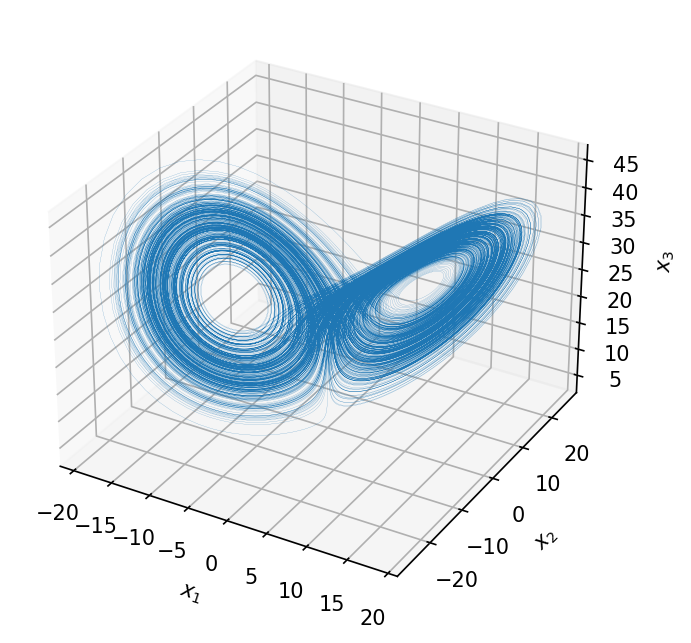

In [4]:
# Import our plotting library
import pylab as plt
import mpl_toolkits.mplot3d.axes3d as plt3

# Set some key attributes like the size and resolution of the figure, and create axis labels
fig = plt.figure(figsize=(6,4), dpi=150)
ax  = plt3.Axes3D(fig)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$x_3$')

# Create the plot of the trajectory and show it
ax.plot3D(X[0,],X[1,],X[2,],linewidth=0.075)
plt.show()

This is the well known "butterfly" attractor. As you can see, the model has two characteristics behaviors or "climatologies." There is one "wing" of the butterfly in which the state variables seemingly oscillate in a plane around some central coordinate. Then, some of these trajectories on that left wing seemingly "jump" off onto the other "wing" of the butterfly. On this wing, or alternate climatology the variables again oscillate in a plane (with a different orientation) around some other point in space. Correspondingly, some of the trajectories on this wing jump onto the other wing. If you look really, really close you can see that some of those trajectories that "switch" from oscillating on one of the butterfly's wings to the other wing seem to be exceptionally close to other trajectories that continue to circulate on the same wing. This is our first clue as to how this sensitive dependence to initial conditions expresses itself.

# Replicating Lorenz's fateful experiment

In the 1960s computers, even at institutions like MIT, were relatively uncommon. When you did have computers they were almost always shared user facilities on which you had to schedule time. As a result, if you wanted to run your model a really long time you would have to: (1) run it as long a period of time as you could get on a shared computer, (2) be careful to record/write the output of your model at the very last time step of your abbreviated model run, and (3) re-start the model when you again had access to computer time, using that saved final condition of the model from your last run as the initial condition. [Note, we still wind up having to do this, but with much, much larger computers and much, much more complex models]. 

When Lorenz did this, he unknowingly used a Fortran command that truncated several digits from the output of the three state variables of his model. After running his model starting from the saved (unknowingly truncated) initial conditions when he could again gain access to a computer, he discovered that at the end of his model run the model state was in a much different location than he anticipated.

Below we are simulating this effect by adding a small, random perturbation to the model states from the very end of our previous model run. And we'll do this twice. We will then re-initialize our model with these new, perturbed initial conditions, and run it forward again for a brief period of time. We'll then plot those two trajectories on top of our "butterfly" attractor to see how they evolved differently due to this small perturbation.  

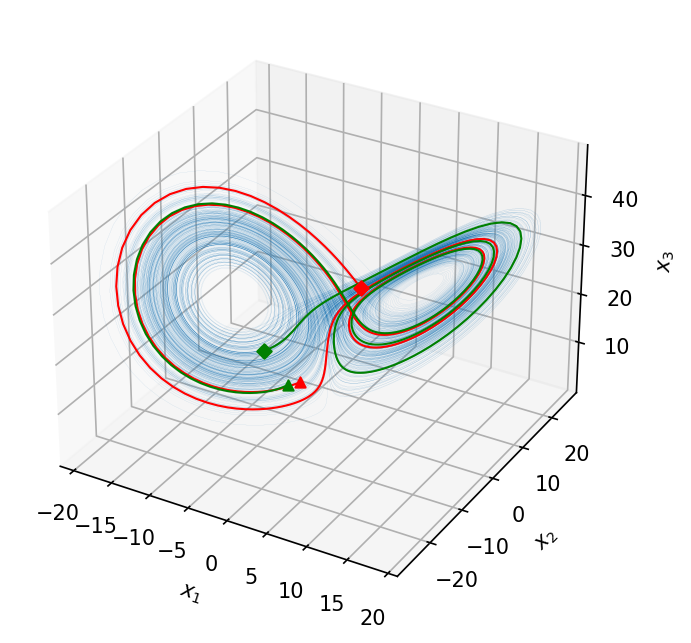

In [11]:
# We're only going to run a short re-run
nt_rerun = 3

# Create two empty arrays to store the trajectories of our perturbed model simulations.
Xp1 = np.zeros(shape=(3,int(nt_rerun/dt)))
Xp2 = np.zeros(shape=(3,int(nt_rerun/dt)))

# Now, take the very last state from our last model run and create two new initial states to re-initialize the model by adding a very small random perturbation. The perturbations will be zero mean with a standard deviation of 0.5
Xa1 = X[:,-1] + np.random.normal(0.0,0.5,3) #0 mean, standard dev 0.5, and i want 3 of them.
Xa2 = X[:,-1] + np.random.normal(0.0,0.5,3)

# This is the run for our first perturbed trajectory. Re-initialize our integration tool with the perturbed initial  state stored in Xa1
r.set_initial_value(Xa1,t0).set_f_params(arg1,arg2,arg3)

i = 0 # This is again a dummy variable
# This is the model integration loop. Again, we run the model as long as the integration tool isn't returning an error  and as long as the time is less than the duration of our re-run simulation
while r.successful() and r.t < nt_rerun-dt:
    r.integrate(r.t+dt)
    Xp1[0,int(i)] = r.y[0] # Save the value of x_1 in the first row and ith column of X
    Xp1[1,int(i)] = r.y[1] # Save the value of x_2 in the second row and ith column of X
    Xp1[2,int(i)] = r.y[2] # Save the value of x_3 in the third row and ith column of X
    i = i + 1 # Iterate our dummy counter by one
    
# This is the run for our second perturbed trajectory. Re-initialize our integration tool with the perturbed initial  state stored in Xa2
r.set_initial_value(Xa2,t0).set_f_params(arg1,arg2,arg3)

i = 0 # This is again a dummy variable
# This is the model integration loop. Again, we run the model as long as the integration tool isn't returning an error  and as long as the time is less than the duration of our re-run simulation
while r.successful() and r.t < nt_rerun-dt:
    r.integrate(r.t+dt)
    Xp2[0,int(i)] = r.y[0] # Save the value of x_1 in the first row and ith column of X
    Xp2[1,int(i)] = r.y[1] # Save the value of x_2 in the second row and ith column of X
    Xp2[2,int(i)] = r.y[2] # Save the value of x_3 in the third row and ith column of X
    i = i + 1 # Iterate our dummy counter by one
    
# Set some key attributes like the size and resolution of the figure, and create axis labels
fig = plt.figure(figsize=(6,4), dpi=150)
ax  = plt3.Axes3D(fig)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$x_3$')

# Plot the original model simulation (but much more faintly), as well as the trajectories of our model runs that  started at the perturbed initial conditions
ax.plot3D(X[0,],X[1,],X[2,],linewidth=0.025)
ax.plot3D(Xp1[0,],Xp1[1,],Xp1[2,],'r',linewidth=1) # ploting experiment 1 
ax.plot3D(Xp2[0,],Xp2[1,],Xp2[2,],'g',linewidth=1) # ploting experiment 2 

# Also show the starting location and ending location of our perturbed model runs as triangles (initial location) and diamonds (final location)
ax.scatter(Xa1[0],Xa1[1],Xa1[2],s=24,c='r',marker='^',zorder=-1) # starting point
ax.scatter(Xa2[0],Xa2[1],Xa2[2],s=24,c='g',marker='^',zorder=-1)
ax.scatter(Xp1[0,-1],Xp1[1,-1],Xp1[2,-1],s=24,c='r',marker='D',zorder=-1) # ending points
ax.scatter(Xp2[0,-1],Xp2[1,-1],Xp2[2,-1],s=24,c='g',marker='D',zorder=-1)

# Show the plot
plt.show()

In the figure above, we again see thethe "wings" of our initial simulation with the Lorenz system of equations, but drawn more faintly. On top of this, we have added these two perturbed simulations (in red and green), along with the location of their perturbed initial state (triangles) and final state (diamonds). As you can see, at the end of our very brief simulation, the two simulations differ dramatically. The green simulation is on the "left wing" while the red simulation is now on the "right wing." 

This shows the nature of this sensitive dependence to our initial condition. We added a relatively small perturbation to our initial condition, and then after running the model a relatively short period of time further the two simulations had diverged significantly. We can think of this as making very small errors in our measurement of air temperature, starting our model with two different estimates of air temperature that are consistent with the accuracy of our thermometer but subtly different, and then subsequently having one model simulation that predicts a heat wave and another that predicts a cold front. Both are physically consistent with the model equations, but arose purely because we couldn't perfectly specify that initial condition. 

## Some questions to ponder
1. If the atmosphere truly exhibits sensitive dependence to initial conditions, then what are some ways that we can combat that sensitive dependence? Stated differently, what if we had added perturbations to our initial condition that had a larger or smaller "accuracy" as captured by the standard deviation in the random noise we added?
2. A common (and sometimes insincere) question that gets asked is, "if you can't predict weather accurately 10 days out, what makes you think you can predict climate 10 years out?" In the toy model above, what parameters dictate what the "climate" of the model is? And what would happen if those parameters changed?
3. Can you think of Earth Systems that are dynamic, but that are probably not sensitively dependent to the initial conditions? What are those systems and how do they differ from the atmosphere?